## Anonymous web data from www.microsoft.com

* This dataset records which areas (Vroots) of www.microsoft.com each user visited in a one-week timeframe in Feburary 1998.
* Source: Jack S. Breese, David Heckerman, Carl M. Kadie.
* The data was created by sampling and processing the www.microsoft.com logs. The size of the sample was 38000 users randomly-selected.
  * Training Instances	32711
  * Testing Instances	5000
  * Attributes	294
  * nonvisits are implicit (missing). 38000 - (32711 + 5000) = 289
* More information: http://kdd.ics.uci.edu/databases/msweb/msweb.data.html

### Data Format

* Attribute lines:
  * For example, 'A,1277,1,"NetShow for PowerPoint","/stream"'
    
    Where:
    * 'A' marks this as an attribute line, 
    * '1277' is the attribute ID number for an area of the website (called a Vroot),
    * '1' may be ignored, 
    * '"NetShow for PowerPoint"' is the title of the Vroot, 
    * '"/stream"' is the URL relative to "http://www.microsoft.com"

* Case and Vote Lines: For each user, there is a case line followed by zero or more vote lines.
  * For example:
    * C,"10164",10164
    * V,1123,1
    * V,1009,1
    * V,1052,1
      
      Where:
      *   'C' marks this as a case line, 
      *   '10164' is the case ID number of a user, 
      *   'V' marks the vote lines for this case, 
      *   '1123', 1009', 1052' are the attributes ID's of Vroots that a user visited. 
      *   '1' may be ignored

## The goal is finding the relationship between web pages using

###  Association Pathern Mining

In [2]:
import re, requests
import bs4
import pandas as pd
import numpy as np

In [2]:
response = requests.get('http://kdd.ics.uci.edu/databases/msweb/msweb.html')
res_bs = bs4.BeautifulSoup(response.content, 'html.parser')

In [116]:
saved_link = []
for a_path in res_bs.find_all('a'):
    if a_path.get('href'):
        #print(a_path)
        if re.search(r'.*\.gz', a_path.get('href')):
            #print(a_path.get('href'))
            #print('http://kdd.ics.uci.edu/databases/msweb/'+ i.get('href'))
            link_to_download = 'http://kdd.ics.uci.edu/databases/msweb/'+ a_path.get('href')
            saved_link.append(link_to_download)

for link_to_download in saved_link:
    name_file = link_to_download.split('/')[-1]
    
    response = requests.get(link_to_download)
    
    with open(f'{name_file}', 'wb') as writer:
        writer.write(response.content)


In [3]:
import gzip

with gzip.open(r'C:\Users\LENOVO\Desktop\projects\3.- STS\anonymous-msweb.data.gz', 'rb') as reader:
    data = reader.read()
    
data_dec = data.decode()

In [4]:
data_list_attrib = re.findall(r'^C.*?(?=C|\n$)',data_dec,  re.MULTILINE|re.DOTALL )
data_user = pd.DataFrame()

for list_attrib in data_list_attrib:
    data_dict = {}
    name_id = re.search(r'["](\d{5})["]',list_attrib).group(1)
    data_dict[name_id] = re.findall(r'\b\d{4}\b',list_attrib)
    
    data_frame = pd.DataFrame(data_dict)
    data_frame_melt = data_frame.melt()
    data_user = data_user.append(data_frame_melt, ignore_index=True)

data_user.columns = ['user_ID', 'attribute_ID']

In [5]:
list_attribute = re.findall(r'A\,(\d{4})\,\d{1}\,["](.*)["]\,["](.*)["]',data_dec)
data_attribute = pd.DataFrame(list_attribute, columns=['attribute_ID', 'title', 'URL'])
data_attribute.URL = 'www.microsoft.com' + data_attribute.URL

In [6]:
data_user_cross = pd.crosstab(data_user['user_ID'], data_user['attribute_ID'])

In [7]:
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import time

**Support**

The support of an itemset $I$ is defined as the fraction of the transactions in the database $T = {T_1 ...T_n}$ that contain $I$ as a subset. The support of an itemset $I$ is denoted by $sup(I)$. *(Data Mining The Textbook - Charu C. Aggarwal - Springer)*

Let $I = \{1034\}$, where $1034$ is the code that identify the `Internet Explorer`.

Let's compute the $sup(I)$

In [8]:
def support(code:set, df:pd.DataFrame):
    support_of_code = (df[code] == 1).all(axis = 1).mean()
    print(f'Support {code} = {support_of_code:.4}')
    return support_of_code

In [9]:
support({'1034'}, data_user_cross)

Support {'1034'} = 0.2868


0.2868454036868332

So, now we will apply the *Association Rule* under the definition of *confidence* 

**Confidence** 

Let $X$ and $Y$ be two sets of items. The confidence $conf(X ∪ Y )$ of the rule $X ∪ Y$ is the conditional probability of $X ∪ Y$ occurring in a transaction, given that the transaction contains $X$. Therefore, the confidence $conf(X ⇒ Y)$ is defined as follows:

$$conf(X ⇒ Y) = \frac{sup(X ∪ Y)}{sup(X)}$$


Given $X = \{1034\}$ and $Y = \{1008\}$, we want to compute the $conf(X \Rightarrow Y)$

In [10]:
from itertools import combinations

In [11]:
def confidence(X:set, Y:set, df:pd.DataFrame) -> float:
    support_of_X = support(X, df)
    XY = X.copy()
    XY.update(Y)
    support_of_XY = support(XY,df)
    print(f'Confidence({X} => {Y}) = {support_of_XY/support_of_X:.4}')
    return support_of_XY/support_of_X

In [12]:
confidence({'1034'}, {'1008'},data_user_cross )

Support {'1034'} = 0.2868
Support {'1034', '1008'} = 0.1608
Confidence({'1034'} => {'1008'}) = 0.5606


0.5605882979857189

In [13]:
def all_support_by_pair(df:pd.DataFrame) -> pd.DataFrame:
    """
    
    --------------------
    """
    df_group = df.groupby(['user_ID'])
    data_to = pd.DataFrame()
    
    for user in df['user_ID'].unique(): #[:200]:
        data_dict = {}
        attribute_ID_by_user = df_group.get_group(user)['attribute_ID']
        data_dict[user] =[*combinations(attribute_ID_by_user, 2)]
        data_frame = pd.DataFrame(data_dict).melt()
        data_to = data_to.append(data_frame, ignore_index=True)
    
    data_to.columns = ['user_ID', 'Support(X U Y)']
    data_to['Support(X U Y)'] = data_to['Support(X U Y)'].apply(lambda x:tuple(sorted(x)))
    data_to_support = data_to['Support(X U Y)'].value_counts()/len(df['user_ID'].unique())
    data_to_support = data_to_support.reset_index()
    data_to_support = data_to_support.rename(columns={'index':'PairPage'})
    
    return  data_to_support

In [14]:
data_visit = all_support_by_pair(data_user)

In [15]:
def all_support_by_one(df:pd.DataFrame) -> pd.DataFrame:
    df_support_one = df.attribute_ID.value_counts()/len(df.user_ID.unique())

    """ 
    The goal of this function is 
    """
    df_support_one = df_support_one.reset_index()
    df_support_one.columns = ['', 'Support']

    return df_support_one

In [16]:
data_support_one = all_support_by_one(data_user)

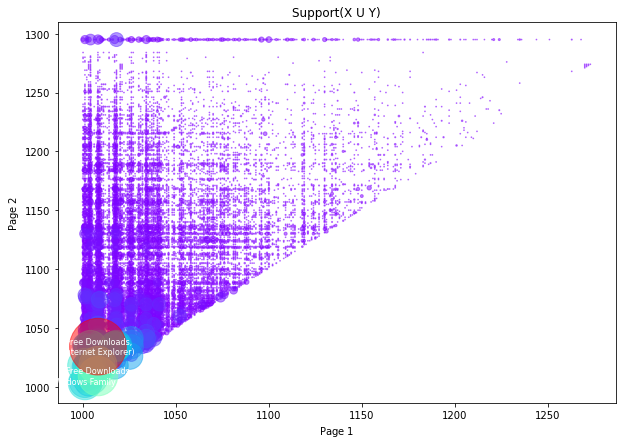

In [17]:
from matplotlib import cm 

fig, ax = plt.subplots(figsize = (10, 7))
data_visit_to_plot = data_visit.sort_values('Support(X U Y)', ascending=True)
x, y = data_visit_to_plot['PairPage'].str.get(0).astype(int), data_visit_to_plot['PairPage'].str.get(1).astype(int)
s = data_visit_to_plot['Support(X U Y)'].copy()

ax.scatter(x, y,c = s, s = s*20000 ,cmap = cm.rainbow , alpha = 0.5 ) # c = c,
ax.set(xlabel='Page $1$', ylabel='Page $2$', title = 'Support(X U Y)')
x_s, y_s = [1008, 1008], [1034, 1009] 
texts = ['(Free Downloads,\n Internet Explorer)', '(Free Downloads,\n Windows Family of OSs)' ]
for x_t, y_t, txt in zip(x_s, y_s, texts): 
    ax.text(x_t, y_t, txt, color = 'white',ha = 'center', va = 'center' , fontsize = 8)
plt.show()

In [18]:
data_visit.set_index('PairPage')['Support(X U Y)'].agg(values=max, Pages = lambda x:x.idxmax())

values        0.160802
Pages     (1008, 1034)
Name: Support(X U Y), dtype: object

The pair of web pages most visited was `Free Downloads and Internet Explores`. 

The $16.08\%$ of the visits that did the people selected were made up of this combination of web pages.

In [19]:
data_visit['X'] = data_visit.PairPage.str.get(0)
data_visit['Y'] = data_visit.PairPage.str.get(1)

In [20]:
data_support_one_X = data_support_one.add_suffix('X')
data_support_one_Y = data_support_one.add_suffix('Y')

In [21]:
data_visit_all = data_visit.merge(data_support_one_X, on = 'X').merge(data_support_one_Y, on = 'Y')

In [22]:
data_visit_all['Support(X U Y)/SupportX'] = data_visit_all['Support(X U Y)'] /data_visit_all['SupportX']
data_visit_all['Support(X U Y)/SupportY'] = data_visit_all['Support(X U Y)'] /data_visit_all['SupportY']

In [23]:
data_visit_all.loc[
    (data_visit_all['SupportX']>0.15)&
    (data_visit_all['SupportY']>0.15), :].sort_values('Support(X U Y)/SupportY', axis = 0, ascending=False)

,PairPage,Support(X U Y),X,Y,SupportX,SupportY,Support(X U Y)/SupportX,Support(X U Y)/SupportY
0,"(1008, 1034)",0.160802,1008,1034,0.331265,0.286845,0.485419,0.560588
43,"(1008, 1018)",0.073064,1008,1018,0.331265,0.162942,0.220561,0.448405
61,"(1008, 1017)",0.061233,1008,1017,0.331265,0.156155,0.184847,0.392130
62,"(1004, 1017)",0.049891,1004,1017,0.258720,0.156155,0.192839,0.319499
44,"(1004, 1018)",0.044786,1004,1018,0.258720,0.162942,0.173106,0.274859
46,"(1017, 1018)",0.036838,1017,1018,0.156155,0.162942,0.235904,0.226079
1,"(1004, 1034)",0.053285,1004,1034,0.258720,0.286845,0.205955,0.185761
11208,"(1004, 1008)",0.060438,1004,1008,0.258720,0.331265,0.233605,0.182447
3,"(1017, 1034)",0.047354,1017,1034,0.156155,0.286845,0.303250,0.165086
5,"(1018, 1034)",0.042982,1018,1034,0.162942,0.286845,0.263790,0.149845


In [24]:
confidence({'1008'}, {'1034'},data_user_cross )

Support {'1008'} = 0.3313
Support {'1034', '1008'} = 0.1608
Confidence({'1008'} => {'1034'}) = 0.4854


0.4854189737910668

# Model

For this purpose, we will choice the best model for classification

In [28]:
data_total = data_attribute.merge(data_user, on = "attribute_ID")

data_total.to_csv('data_microsoft.csv', sep =',', index = False)

In [29]:
data_total = pd.read_csv('data_microsoft.csv', sep=',')

In [30]:
data_total.groupby('user_ID')['attribute_ID'].count()

user_ID
10001    3
10002    2
10003    3
10004    1
10005    1
        ..
42707    6
42708    6
42709    2
42710    3
42711    1
Name: attribute_ID, Length: 32711, dtype: int64

In [10]:
data_total.sort_values('user_ID')

,attribute_ID,title,URL,user_ID
70189,1002,"""End User Produced View""",http://www.microsoft.com/athome,10001
80199,1000,"""regwiz""",http://www.microsoft.com/regwiz,10001
34683,1001,"""Support Desktop""",http://www.microsoft.com/support,10001
13576,1003,"""Knowledge Base""",http://www.microsoft.com/kb,10002
34684,1001,"""Support Desktop""",http://www.microsoft.com/support,10002
...,...,...,...,...
39132,1001,"""Support Desktop""",http://www.microsoft.com/support,42709
16543,1003,"""Knowledge Base""",http://www.microsoft.com/kb,42709
39133,1001,"""Support Desktop""",http://www.microsoft.com/support,42710
97205,1018,"""isapi""",http://www.microsoft.com/isapi,42710


In [12]:
cross_user_attr = pd.crosstab(data_total['user_ID'], data_total['attribute_ID'])

In [13]:
cross_user_attr

attribute_ID,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1276,1277,1278,1279,1280,1281,1282,1283,1284,1295
user_ID,,,,,,,,,,,,,,,,,,,,,
10001,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10005,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42706,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42707,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
42708,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


References
* *Introduction to Probability Second Edition* - CHAPMAN & HALL/CRC Texts in Statistical Science Series Joseph K. Blitzstein, Harvard University, USA Julian J. Faraway, University of Bath, UK Martin Tanner, Northwestern University, USA Jim Zidek, University of British Columbia, Canada